In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import shutil

In [12]:
train_path = "/Users/chloelsmith/Desktop/archive-2/Grayscale_Training"
test_path = "/Users/chloelsmith/Desktop/archive-2/Grayscale_Testing"
clean_train_path = "/Users/chloelsmith/Desktop/archive-2/Outlier_Removed_Grayscale_Training"
clean_test_path = "/Users/chloelsmith/Desktop/archive-2/Outlier_Removed_Grayscale_Testing"



In [13]:
def dataset_to_numpy(dataset):
    images = []
    for x, _ in dataset:
        images.append(x.numpy())
    return np.concatenate(images, axis=0)

def show_outliers(images, indices, title, n=50, cols=10, random_sample=True):
   
    n = min(n, len(indices))
    
    if random_sample:
        indices_to_show = np.random.choice(indices, size=n, replace=False)
    else:
        indices_to_show = indices[:n]
    
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols*2, rows*2))
    
    for i, idx in enumerate(indices_to_show):
        plt.subplot(rows, cols, i+1)
        img = images[int(idx)]
        if img.shape[-1] == 3:
            plt.imshow(img)
        else:
            plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def reconstruction_errors(model, dataset):
    errors = []
    for x, _ in dataset:
        recon = model(x, training=False)
        mse = tf.reduce_mean(tf.square(x - recon), axis=[1, 2, 3])
        errors.append(mse.numpy())
    return np.concatenate(errors)

def copy_folder_excluding_paths(src_folder, dst_folder, exclude_paths):
    exclude_paths = [os.path.abspath(p) for p in exclude_paths]
    for root, dirs, files in os.walk(src_folder):
        rel_path = os.path.relpath(root, src_folder)
        target_root = os.path.join(dst_folder, rel_path)
        os.makedirs(target_root, exist_ok=True)
        for file in files:
            src_file = os.path.abspath(os.path.join(root, file))
            if src_file not in exclude_paths:
                dst_file = os.path.join(target_root, file)
                shutil.copy2(src_file, dst_file)

In [14]:

IMG_SIZE = (96, 96)
BATCH_SIZE = 32
EPOCHS = 3
VAL_FRACTION = 0.1


raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=None,
    shuffle=False
)

raw_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=None,
    shuffle=False
)

# Capture file paths BEFORE mapping/prefetching
train_paths = raw_train_ds.file_paths
test_paths = raw_test_ds.file_paths

# Normalize and prepare autoencoder input
train_ds = raw_train_ds.map(lambda x: x / 255.0)
test_ds = raw_test_ds.map(lambda x: x / 255.0)

train_ds = train_ds.map(lambda x: (x, x))
test_ds = test_ds.map(lambda x: (x, x))

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

num_batches = train_ds.cardinality().numpy()
val_batches = max(1, int(num_batches * VAL_FRACTION))
val_ds = train_ds.take(val_batches)
train_ds_final = train_ds.skip(val_batches)


autoencoder = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    # Encoder
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    # Decoder
    layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2D(3, 3, activation='sigmoid', padding='same')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


autoencoder.fit(train_ds_final, validation_data=val_ds, epochs=EPOCHS, verbose=1)


train_recon = reconstruction_errors(autoencoder, train_ds)
test_recon = reconstruction_errors(autoencoder, test_ds)

threshold = np.percentile(train_recon, 97.5)
print(f"Outlier threshold (97.5th percentile): {threshold:.6f}")

train_outliers_idx = np.where(train_recon > threshold)[0]
test_outliers_idx = np.where(test_recon > threshold)[0]

train_outlier_paths = [train_paths[i] for i in train_outliers_idx]
test_outlier_paths = [test_paths[i] for i in test_outliers_idx]

print(f"Train outliers: {len(train_outlier_paths)}")
print(f"Test outliers: {len(test_outlier_paths)}")


# Copy train and test folders without outliers
copy_folder_excluding_paths(train_path, clean_train_path, train_outlier_paths)
copy_folder_excluding_paths(test_path, clean_test_path, test_outlier_paths)

print("Folders copied with outliers removed.")


Found 5521 files.
Found 1205 files.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 24, 24, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 48, 48, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 96, 96, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 96, 96, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
156/156 ━━━━━━━━━━━━━━━━━━━━ 81s 499ms/step - loss: 0.0847 - val_loss: 0.0317
Epoch 2/3
156/156 ━━━━━━━━━━━━━━━━━━━━ 77s 495ms/step - loss: 0.0770 - val_loss: 0.0317
Epoch 3/3
156/156 ━━━━━━━━━━━━━━━━━━━━ 76s 487ms/step - loss: 0.0770 - val_loss: 0.0317


2025-12-17 14:26:23.536321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-12-17 14:26:32.120004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Outlier threshold (97.5th percentile): 0.222666
Train outliers: 138
Test outliers: 36
Folders copied with outliers removed.


2025-12-17 14:26:37.773721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-12-17 14:26:38.558019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


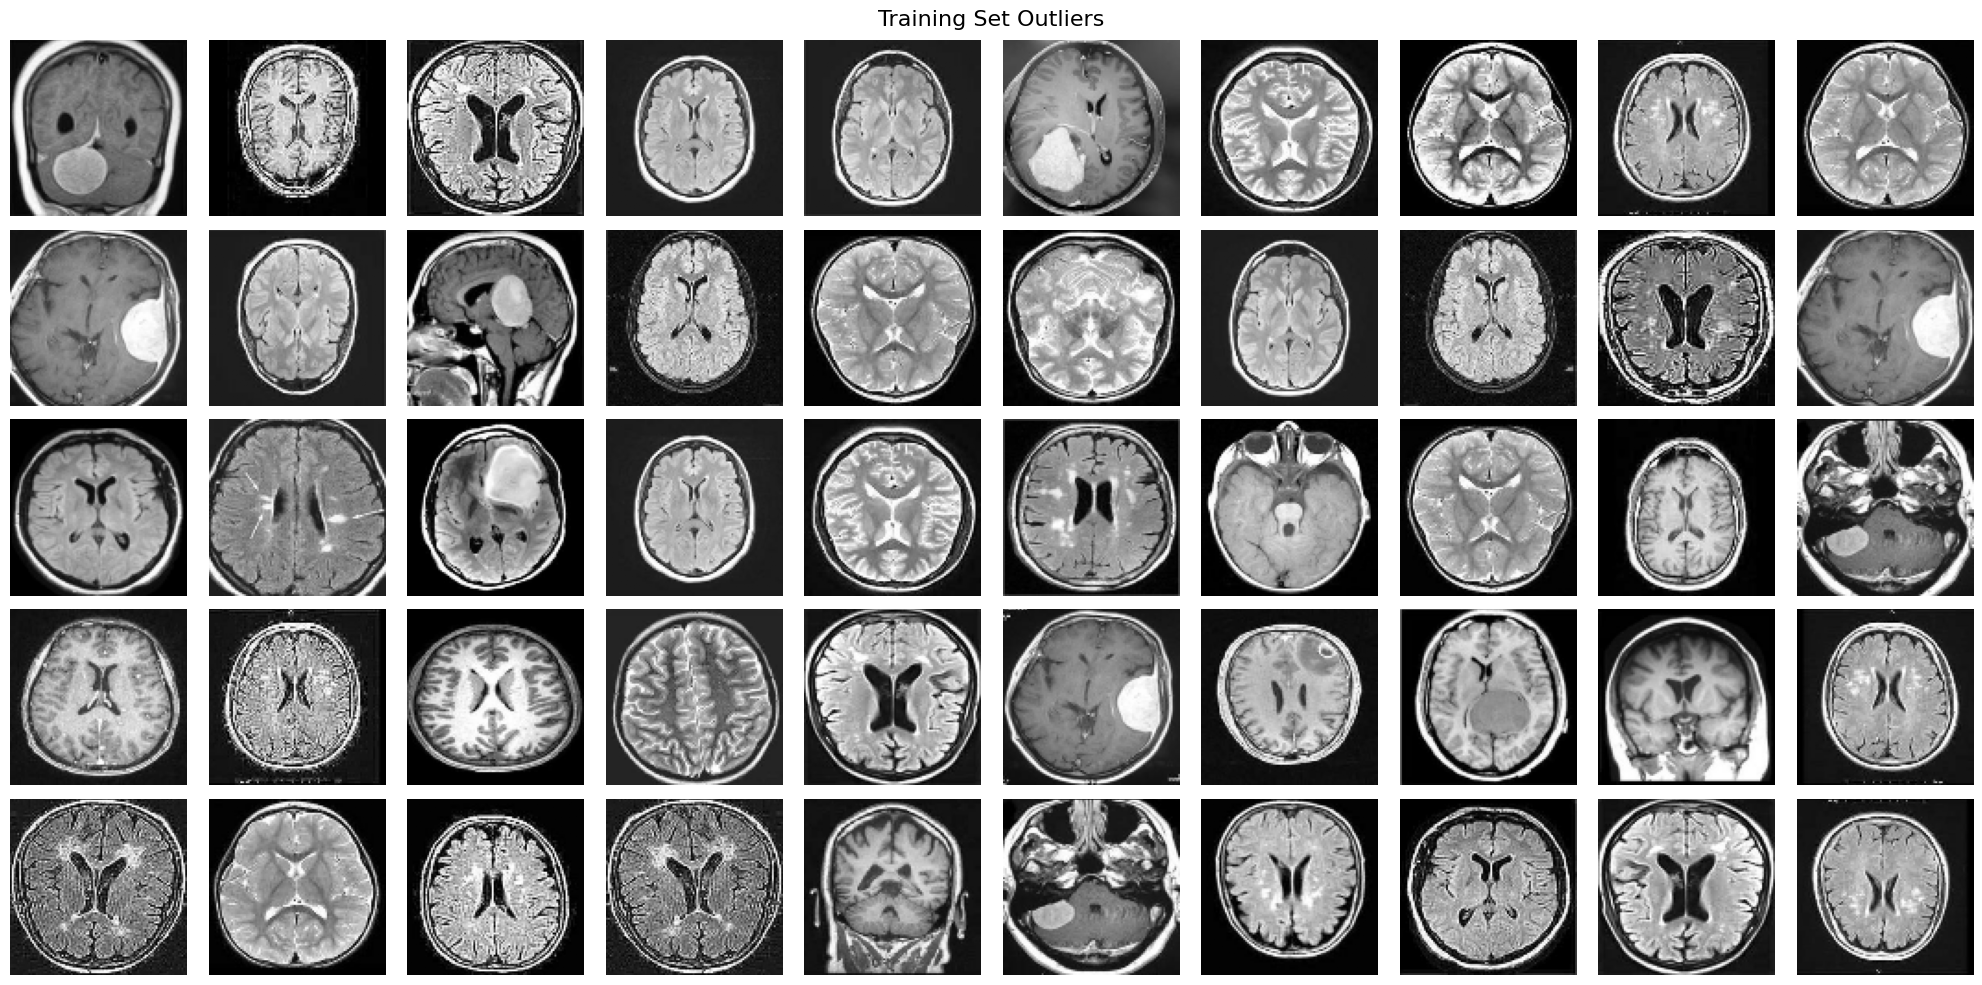

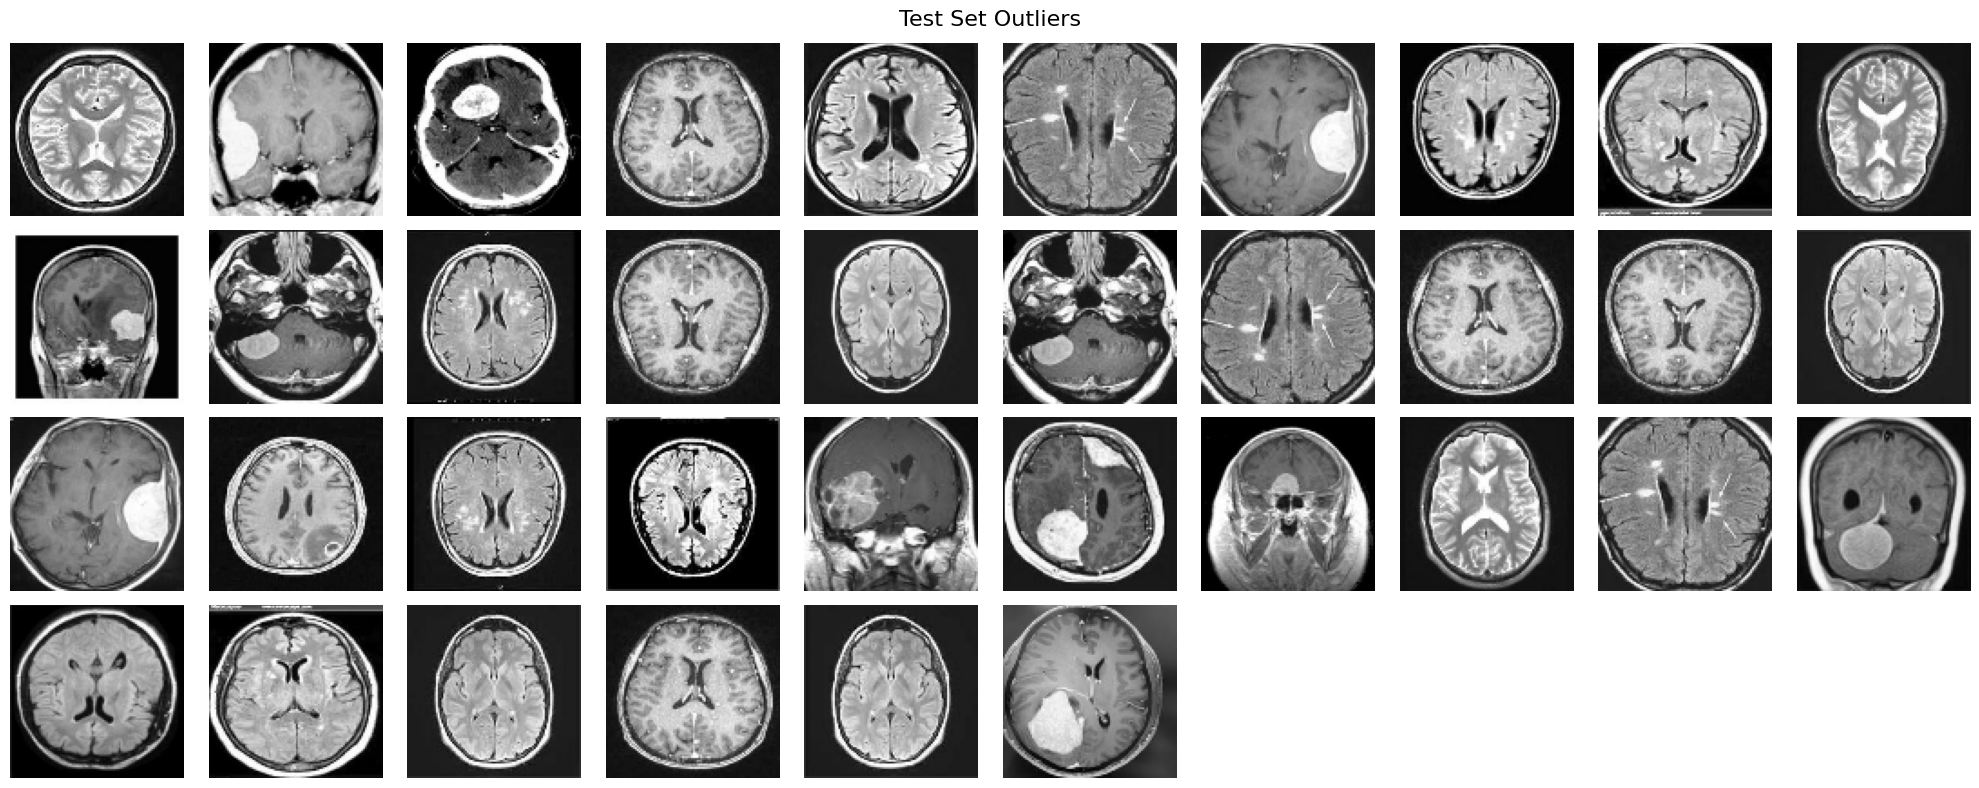

In [15]:
# Convert train and test datasets
X_train_np = dataset_to_numpy(train_ds)
X_test_np = dataset_to_numpy(test_ds)

show_outliers(X_train_np, train_outliers_idx, "Training Set Outliers")
show_outliers(X_test_np, test_outliers_idx, "Test Set Outliers")